##[Table of Contents](#scrollTo=0mk4Qx35WAEN)

>[1. Initial Setup](#scrollTo=0mk4Qx35WAEN)

>>[Some Basic Information](#scrollTo=CrCyiHx0WDih)

>[2. EDA (Exploratory Data Analysis)](#scrollTo=mUz6d8AeWJD0)

>>[2.1. Images Statistical Data](#scrollTo=uwFv9WTsX-nD)

>>[2.2. Labels Statistical Data](#scrollTo=9FBGBerlYu0W)

>>[2.3. Data Visualization](#scrollTo=D7SJApLYZWNA)



# **1. Initial Setup**

In [ ]:
!pip install -q kaggle
import os

!mkdir ~/.kaggle

# Figures export directory
if not os.path.isdir(f'{os.getcwd()}/plots'):
    os.mkdir(f'{os.getcwd()}/plots')

if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
    from google.colab import files
    print("Upload kaggle.json here")
    files.upload()

!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload kaggle.json here


Saving kaggle.json to kaggle.json


In [ ]:
dataset_name = 'pkdarabi/medical-image-dataset-brain-tumor-detection'
zip_name = dataset_name.split('/')[-1]

!kaggle datasets download -d {dataset_name} --force
!unzip -o -q ./{zip_name}.zip -d .

100% 55.6M/55.6M [00:11<00:00, 4.00MB/s]
100% 55.6M/55.6M [00:11<00:00, 4.99MB/s]


## **Some Basic Information**

- Some images doesn't have any tumor to detect;

- Each label file (.txt) has the following pattern in each line (if it's tumourous):
    - \<label\> \<coordinate 1\> \<coordinate 2\> \<coordinate 3\> \<coordinate 4\>.

- The dataset is already splitted between train, validation and test sets (70%, 20% and 10%, respectively).

In [ ]:
# An instance with no tumour to detect
!cat 'Brain Tumor Detection/train/labels/volume_82_slice_53_jpg.rf.9b9cb2b7f64aad43328bb42413e71a0d.txt'

In [ ]:
# An instance with all tumour types to detect and their coordinates
!cat 'Brain Tumor Detection/train/labels/volume_348_slice_114_jpg.rf.65558903adffdcfb7286287dda3477dd.txt'

0 0.7086330935251799 0.5757575757575758 0.17985611510791366 0.12121212121212122
1 0.7086330935251799 0.6136363636363636 0.2949640287769784 0.22727272727272727
2 0.7050359712230215 0.6060606060606061 0.2446043165467626 0.22727272727272727

# **2. EDA (Exploratory Data Analysis)**

In [ ]:
!pip install pycryptodomex -q

from Cryptodome.Hash import SHA512
import numpy as np
import cv2   as cv


hash_function = SHA512.new()


def count_duplicates(data_dir: str) -> tuple[int, list]:
    '''
    Counts duplicated images and which of them aren't tumourous
    '''
    no_tumour = 0
    images, labels, hashes = list(), list(), list()

    for filename in os.listdir(os.path.join(data_dir, 'images')):

        if filename.endswith('.jpg') or filename.endswith('.png'):

            img_path = os.path.join(data_dir, 'images', filename)
            img = cv.imread(img_path)

            # Calculates the hash for each image (needs conversion to bytes)
            _, image_bytes = cv.imencode('.jpg', img)
            image_bytes = image_bytes.tobytes()
            hash_function.update(image_bytes)
            img_hash = hash_function.hexdigest()
            hashes.append(img_hash)

            label_path = os.path.join(data_dir, 'labels', filename.replace('.jpg', '.txt'))

            if os.path.isfile(label_path):
                with open(label_path, 'r') as label_file:
                    line = label_file.readline().strip()

                    if not line:
                        no_tumour += 1
                        continue

    return no_tumour, hashes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00


- All images are labeled (even if it has no tumors);

- No duplicated instances;

- The portion of images with no tumor is minimal;

- Low number of images with no tumour can lead to overfitting of the model (e.g., tends to detect at least one tumour every time).

In [ ]:
image_hashes = list()
total_images, n_labels, unlabeled = 0, 0, 0
dirs = ['Brain Tumor Detection/train', 'Brain Tumor Detection/valid', 'Brain Tumor Detection/test']

for dir in dirs:
    partial_unlabeled, partial_hash = count_duplicates(data_dir=dir)
    unlabeled += partial_unlabeled
    image_hashes += partial_hash
    n_labels += len(os.listdir(f'{dir}/labels'))
    total_images += len(os.listdir(f'{dir}/images'))

proportion = (unlabeled / total_images) * 100
duplicates = len(image_hashes) - len(list(set(image_hashes)))
print(f'Total amount of images: {total_images}')
print(f'Total amount of labels: {n_labels}')
print(f'Amount of images with no tumors: {unlabeled} ({round(proportion, 2)}%)')
print(f'Redundant images: {duplicates}')

Total amount of images: 9900
Total amount of labels: 9900
Amount of images with no tumors: 113 (1.14%)
Redundant images: 0


## **2.1. Images Statistical Data**


In [ ]:
def calculate_image_statistics(image_path: str) -> tuple[int, int, float, int, int, float, int]:

    image = cv.imread(image_path)

    height, width = image.shape[0], image.shape[1]
    mean = np.mean(image)
    maximum = np.amax(image)
    minimum = np.amin(image)
    std_dev = np.std(image)
    channels = 3 if len(image.shape) == 3 else 1

    return height, width, mean, maximum, minimum, std_dev, channels

In [ ]:
import pandas as pd

image_statistics = list()

# Iterate through each image in each directory
for dir in dirs:
    for filename in os.listdir(f'{dir}/images'):

        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(f'{dir}/images', filename)
            statistics = calculate_image_statistics(image_path=image_path)
            image_statistics.append([filename] + list(statistics))

columns = ['Filename', 'Height', 'Width', 'Pixels Mean', 'Max', 'Min', 'Std Dev', 'Channels']
dataset = pd.DataFrame(image_statistics, columns=columns)

dataset.to_csv('image_statistics.csv', index=False)

In [ ]:
dataset.head()

,Filename,Height,Width,Pixels Mean,Max,Min,Std Dev,Channels
0,volume_140_slice_81_jpg.rf.5cf08969834f70f7eaf...,132,139,42.991371,255,0,28.961567,3
1,volume_155_slice_65_jpg.rf.05248f2c2c25d4d04cc...,132,139,44.835604,247,0,38.561719,3
2,volume_185_slice_38_jpg.rf.c8eff3503d3e25d6edd...,132,139,30.189775,255,0,35.587952,3
3,volume_181_slice_86_jpg.rf.cc4908b2948d011fd45...,132,139,42.372248,255,0,34.547741,3
4,volume_358_slice_55_jpg.rf.63f86111b3df0451f69...,132,139,34.488991,244,0,39.200784,3


- All images have the same resolution (139 x 132) and number of channels (BGR);

- Standard deviation and mean by image pixels don't look to be presenting outliers.

In [ ]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Height,9900.0,132.000000,0.000000,132.000000,132.000000,132.000000,132.000000,132.000000
Width,9900.0,139.000000,0.000000,139.000000,139.000000,139.000000,139.000000,139.000000
Pixels Mean,9900.0,41.491556,14.435262,0.635728,29.985721,41.002698,51.823977,86.938213
Max,9900.0,248.378182,10.725694,164.000000,244.000000,255.000000,255.000000,255.000000
Min,9900.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Std Dev,9900.0,34.996337,6.389324,7.300948,30.866113,34.577082,38.756146,70.697975
Channels,9900.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000


- All measured image standard deviations are unique, confirming that the dataset doesn't have any duplicates.

In [ ]:
dataset.nunique()

Filename       9900
Height            1
Width             1
Pixels Mean    9877
Max              71
Min               1
Std Dev        9900
Channels          1
dtype: int64

In [ ]:
print(f'Duplicated rows: {dataset.duplicated().sum()}')

Duplicated rows: 0


## **2.2. Labels Statistical Data**

In [ ]:
correspondences = {0: 'Glioma', 1: 'Meningioma', 2: 'Metastatic'}


def process_txt_file(file_path: str) -> pd.DataFrame:

    each_instance = pd.DataFrame(columns=['Glioma', 'Meningioma', 'Metastatic', 'No Tumour'])
    label_counts = dict()
    total_count = 0

    with open(file_path, 'r') as txtfile:

        for line in txtfile:

            # Split the line into label and coordinates
            label = line.strip().split()[0]
            label_name = correspondences[int(label)]

            # Increments the label count
            label_counts[label] = label_counts.get(label, 0) + 1
            each_instance[label_name] = [label_counts[label]]
            total_count += 1

        if total_count == 0:
            each_instance['No Tumour'] = [1]

    # If the instance doesn't have all labels
    each_instance = each_instance.fillna(0)

    each_instance['File Name'] = os.path.basename(file_path)
    each_instance['Total'] = total_count

    return each_instance


def create_csv_labels(input_dir: str) -> pd.DataFrame:

    instances = list()

    # Iterate through each file in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(input_dir, filename)

            each_instance = process_txt_file(file_path)
            instances.append(each_instance)

    merged_df = pd.concat(instances, ignore_index=True)
    return merged_df

In [ ]:
labels_csv = pd.DataFrame()
for dir in dirs:
    each_dir = create_csv_labels(input_dir=f'{dir}/labels')
    labels_csv = pd.concat([labels_csv, each_dir], ignore_index=True)

labels_csv.to_csv('label.csv', index=False)

In [ ]:
labels_csv.head()

,Glioma,Meningioma,Metastatic,No Tumour,File Name,Total
0,1,1,1,0,volume_246_slice_76_jpg.rf.4c8a122c7c77a8ec82a...,3
1,1,1,1,0,volume_205_slice_85_jpg.rf.80a9c069d01e224ed99...,3
2,1,1,1,0,volume_104_slice_69_jpg.rf.f69ea93552041e51477...,3
3,0,1,0,0,volume_243_slice_81_jpg.rf.5153f22f40a5069a8f4...,1
4,1,1,1,0,volume_323_slice_79_jpg.rf.fad7fe969ab456a1234...,3


- The dataset is extremely unbalanced, both in detection and classification;

- Meningioma type of tumour has a majoritary presence in the dataset;

- Each type of tumour is present in at least half of the dataset;

- More than half of the images in the dataset have 3 tumours to detect;

- All images don't have more than one tumour from the same type;

- In other words, each image has at most, 3 tumours to detect.

In [ ]:
labels_csv.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Glioma,9900.0,0.613333,0.487011,0.0,0.0,1.0,1.0,1.0
Meningioma,9900.0,0.974848,0.156593,0.0,1.0,1.0,1.0,1.0
Metastatic,9900.0,0.586061,0.492563,0.0,0.0,1.0,1.0,1.0
No Tumour,9900.0,0.011414,0.106231,0.0,0.0,0.0,0.0,1.0
Total,9900.0,2.174242,0.917356,0.0,1.0,3.0,3.0,3.0


In [ ]:
labels_csv.nunique()

Glioma           2
Meningioma       2
Metastatic       2
No Tumour        2
File Name     9900
Total            4
dtype: int64

In [ ]:
# All possible combinations for tumour types and quantities in images
tumour_dist = labels_csv.groupby(['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']).sum().reset_index()
tumour_dist[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']]

,Glioma,Meningioma,Metastatic,No Tumour
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,1,0
4,1,0,0,0
5,1,0,1,0
6,1,1,0,0
7,1,1,1,0


In [ ]:
labels_csv[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']].sum()

Glioma        6072
Meningioma    9651
Metastatic    5802
No Tumour      113
dtype: int64

In [ ]:
labels_csv['Total'].value_counts()

Total
3    5065
1    3114
2    1608
0     113
Name: count, dtype: int64

## **2.3. Data Visualization**

- Standard deviation follows the shape of an asymmetric Gaussian distribution;

- This means that there the amount of outliers with extreme low and/or high std is minimal;

- A high amount of images with low std would mean that many images have low constrast, which could be problematic for segmentation process;

- Since most of the std measures are concentrated in the range [20, 50], it is possible that such problems with contrast won't happen;

- Otherwise, we could make use of DPI techniques (e.g., histogram equalization) to change the pixel values distributions of some images, enhancing contrast.

![hist](https://www.researchgate.net/profile/Alexander-Toet/publication/269694707/figure/fig1/AS:613512946655267@1523284293454/Example-of-histogram-equalization-a-The-input-image-and-b-its-graylevel-histogram.png)

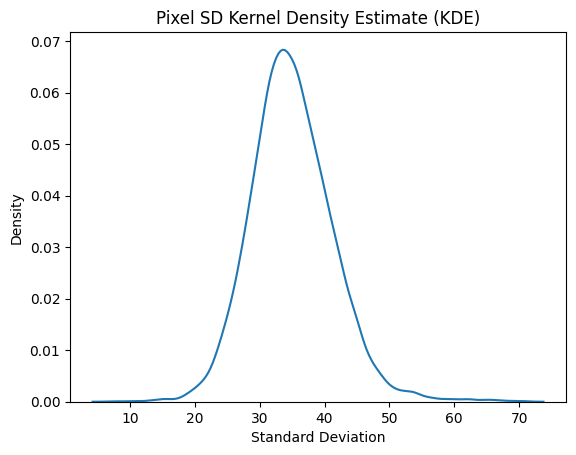

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data=dataset, x="Std Dev")
plt.title('Pixel SD Kernel Density Estimate (KDE)')
plt.xlabel('Standard Deviation')

plt.savefig(f'{os.getcwd()}/plots/std_distribution.png', format='png')
plt.show()

- Pixels mean is a metric that isn't very useful for extracting insigths;

- Although, we can see in the graph below that the vast majority of the images aren't "too dark" or "too bright".

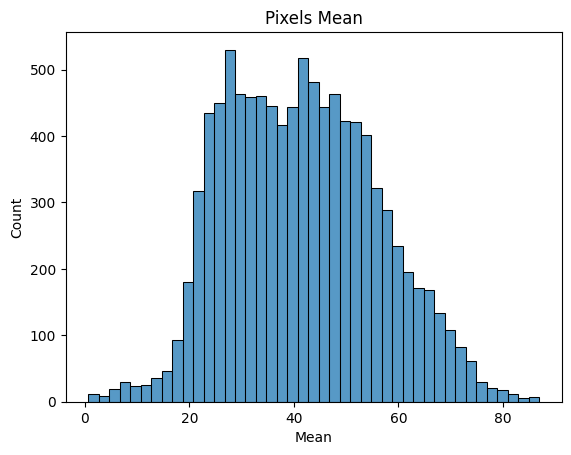

In [ ]:
sns.histplot(data=dataset, x='Pixels Mean')
plt.title('Pixels Mean')
plt.xlabel('Mean')

plt.savefig(f'{os.getcwd()}/plots/mean_hist.png', format='png')
plt.show()

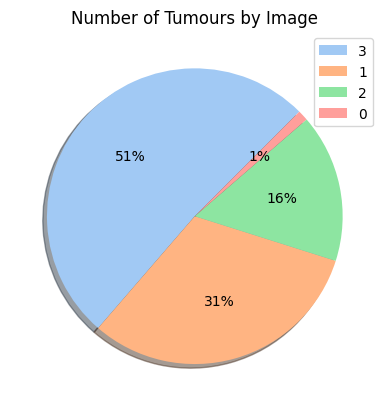

In [ ]:
split = labels_csv['Total'].value_counts()
colors = sns.color_palette('pastel')[0:5]

plt.pie(split, colors=colors, shadow=True, startangle=45, autopct='%.0f%%')
plt.title('Number of Tumours by Image')
plt.legend([3, 1, 2, 0], loc='best')

plt.savefig(f'{os.getcwd()}/plots/tumour_qtt_dist.png', format='png')
plt.show()

In [ ]:
!pip install -U kaleido -q
import plotly.express as px


amount = labels_csv[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']].sum()
fig = px.bar(x=['Glioma', 'Meningioma', 'Metastatic', 'No Tumour'], y=amount,
             color=['blue', 'blue', 'blue', 'red'], title='Class Distribution',
             labels={'x': 'Class', 'y': 'Amount'}, width=800, height=600)

fig.update_layout(showlegend=False)
fig.show()
fig.write_image(f'{os.getcwd()}/plots/class_dit.png')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.5 MB/s eta 0:00:00


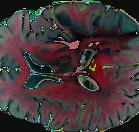

In [ ]:
from google.colab.patches import cv2_imshow


# Visualizing classes
img_filter = labels_csv.query('Glioma == 0 & Meningioma == 1 & Metastatic == 0 & `No Tumour` == 0')['File Name'].iloc[0]
my_img = cv.imread(f'Brain Tumor Detection/train/images/{img_filter.replace(".txt", ".jpg")}')
cv2_imshow(my_img)